<a href="https://colab.research.google.com/github/sanchitgulati/ML-notebooks/blob/main/VGG19_ImageTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Based on Neural Style Transfer with TensorFlow by [pawangfg](https://www.geeksforgeeks.org/neural-style-transfer-with-tensorflow/)

In [26]:
# import numpy, tensorflow and matplotlib
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
# import VGG 19 model and keras Model API
from tensorflow.keras.applications import vgg19
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.python.keras.models import Model

In [11]:
# Image Credits: Tensorflow Doc
content_path = tf.keras.utils.get_file('content.jpg',
									'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('style.jpg',
									'https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')


195196/195196 [==============================] - 0s 0us/step


In [12]:
# code
# this function download the VGG model and initialise it
model = VGG19(
	include_top=False,
	weights='imagenet'
)
# set training to False
model.trainable = False
# Print details of different layers

model.summary()


80134624/80134624 [==============================] - 0s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [13]:

# code to load and process image
def load_and_process_image(image_path):
	img = load_img(image_path)
	# convert image to array
	img = img_to_array(img)
	img = tf.keras.applications.vgg19.preprocess_input(img)
	img = np.expand_dims(img, axis=0)
	return img


In [14]:
# code
def deprocess(img):
	# perform the inverse of the pre processing step
	img[:, :, 0] += 103.939
	img[:, :, 1] += 116.779
	img[:, :, 2] += 123.68
	# convert RGB to BGR
	img = img[:, :, ::-1]

	img = np.clip(img, 0, 255).astype('uint8')
	return img


def display_image(image):
	# remove one dimension if image has 4 dimension
	if len(image.shape) == 4:
		img = np.squeeze(image, axis=0)

	img = deprocess(img)

	plt.grid(False)
	plt.xticks([])
	plt.yticks([])
	plt.imshow(img)
	return


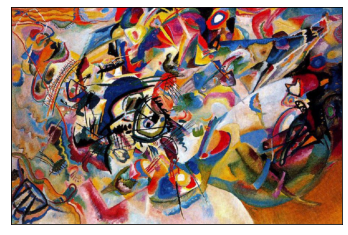

In [15]:
# load content image
content_img = load_and_process_image(content_path)
display_image(content_img)

# load style image
style_img = load_and_process_image(style_path)
display_image(style_img)


In [16]:
# define content model
content_layer = 'block5_conv2'
content_model = Model(
	inputs=model.input,
	outputs=model.get_layer(content_layer).output
)
content_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Total params: 15,304,768
Trainable params: 0
Non-trainable params: 15,304,768
_________________________________________________________________


In [17]:
# define style model
style_layers = [
	'block1_conv1',
	'block3_conv1',
	'block5_conv1'
]
style_models = [Model(inputs=model.input,
					outputs=model.get_layer(layer).output) for layer in style_layers]


In [18]:
# Content loss
def content_loss(content, generated):
	a_C = content_model(content)
	loss = tf.reduce_mean(tf.square(a_C - a_G))
	return loss


In [19]:
# gram matrix
def gram_matrix(A):
	channels = int(A.shape[-1])
	a = tf.reshape(A, [-1, channels])
	n = tf.shape(a)[0]
	gram = tf.matmul(a, a, transpose_a=True)
	return gram / tf.cast(n, tf.float32)


weight_of_layer = 1. / len(style_models)


# style loss
def style_cost(style, generated):
	J_style = 0

	for style_model in style_models:
		a_S = style_model(style)
		a_G = style_model(generated)
		GS = gram_matrix(a_S)
		GG = gram_matrix(a_G)
		current_cost = tf.reduce_mean(tf.square(GS - GG))
		J_style += current_cost * weight_of_layer

	return J_style


In [34]:
# training function
generated_images = []

def training_loop(content_path, style_path, iterations=50, a=10, b=1000):
	# load content and style images from their respective path
	content = load_and_process_image(content_path)
	style = load_and_process_image(style_path)
	generated = tf.Variable(content, dtype=tf.float32)

	opt = tf.keras.optimizers.Adam(learning_rate=7)

	best_cost = math.inf
	best_image = None
	for i in range(iterations):
		%time
		with tf.GradientTape() as tape:
			J_content = style_cost(content, generated)
			J_style = style_cost(style, generated)
			J_total = a * J_content + b * J_style

		grads = tape.gradient(J_total, generated)
		opt.apply_gradients([(grads, generated)])

		if J_total < best_cost:
			best_cost = J_total
			best_image = generated.numpy()

		print("Iteration :{}".format(i))
		print('Total Loss {:e}.'.format(J_total))
		generated_images.append(generated.numpy())

	return best_image


In [35]:
# Train the model and get best image
final_img = training_loop(content_path, style_path)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 17.4 µs
Iteration :0
Total Loss 5.133926e+11.
CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs
Iteration :1
Total Loss 3.514027e+11.
CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 8.82 µs
Iteration :2
Total Loss 2.088912e+11.
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Iteration :3
Total Loss 1.705002e+11.
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Iteration :4
Total Loss 1.606080e+11.
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.82 µs
Iteration :5
Total Loss 1.230377e+11.
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Iteration :6
Total Loss 9.180513e+10.
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs
Iteration :7
Total Loss 7.565396e+10.
CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 16.9 µs
Iteration :8
Total Loss 6.619344e+10.
CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 8.34 µs
Iteration :9
T

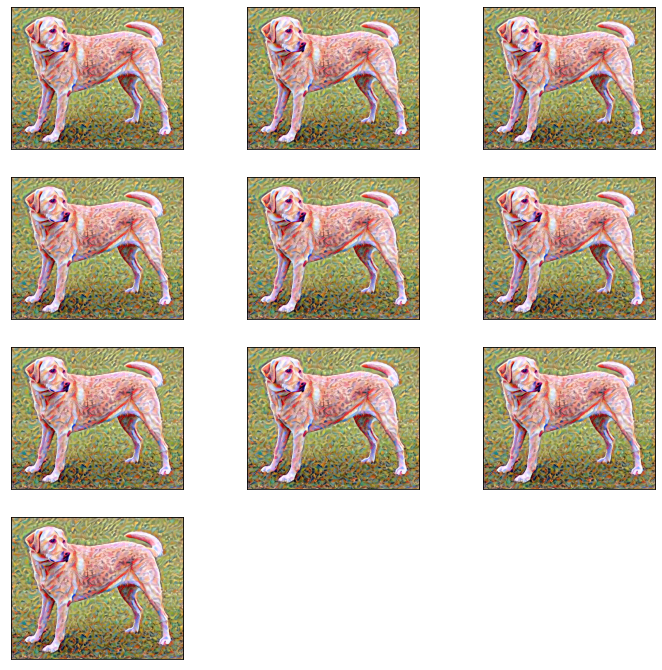

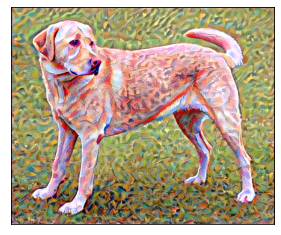

In [36]:
# code to display best generated image and last 10 intermediate results
plt.figure(figsize=(12, 12))

for i in range(10):
	plt.subplot(4, 3, i + 1)
	display_image(generated_images[i+39])
plt.show()

# plot best result
display_image(final_img)
